In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/equity-post-HCT-survival-predictions/sample_submission.csv
/kaggle/input/equity-post-HCT-survival-predictions/data_dictionary.csv
/kaggle/input/equity-post-HCT-survival-predictions/train.csv
/kaggle/input/equity-post-HCT-survival-predictions/test.csv


In [2]:
path = "/kaggle/input/equity-post-HCT-survival-predictions"

train_df = pd.read_csv(f"{path}/train.csv")
test_df = pd.read_csv(f"{path}/test.csv")
data_dict = pd.read_csv(f"{path}/data_dictionary.csv")
sub_df = pd.read_csv(f"{path}/sample_submission.csv")

In [3]:
test_df

,ID,dri_score,psych_disturb,cyto_score,diabetes,hla_match_c_high,hla_high_res_8,tbi_status,arrhythmia,hla_low_res_6,...,karnofsky_score,hepatic_mild,tce_div_match,donor_related,melphalan_dose,hla_low_res_8,cardiac,hla_match_drb1_high,pulm_moderate,hla_low_res_10
0,28800,N/A - non-malignant indication,No,NaN,No,NaN,NaN,No TBI,No,6.0,...,90.0,No,NaN,Unrelated,"N/A, Mel not given",8.0,No,2.0,No,10.0
1,28801,Intermediate,No,Intermediate,No,2.0,8.0,"TBI +- Other, >cGy",No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,Yes,10.0
2,28802,N/A - non-malignant indication,No,NaN,No,2.0,8.0,No TBI,No,6.0,...,90.0,No,Permissive mismatched,Related,"N/A, Mel not given",8.0,No,2.0,No,10.0


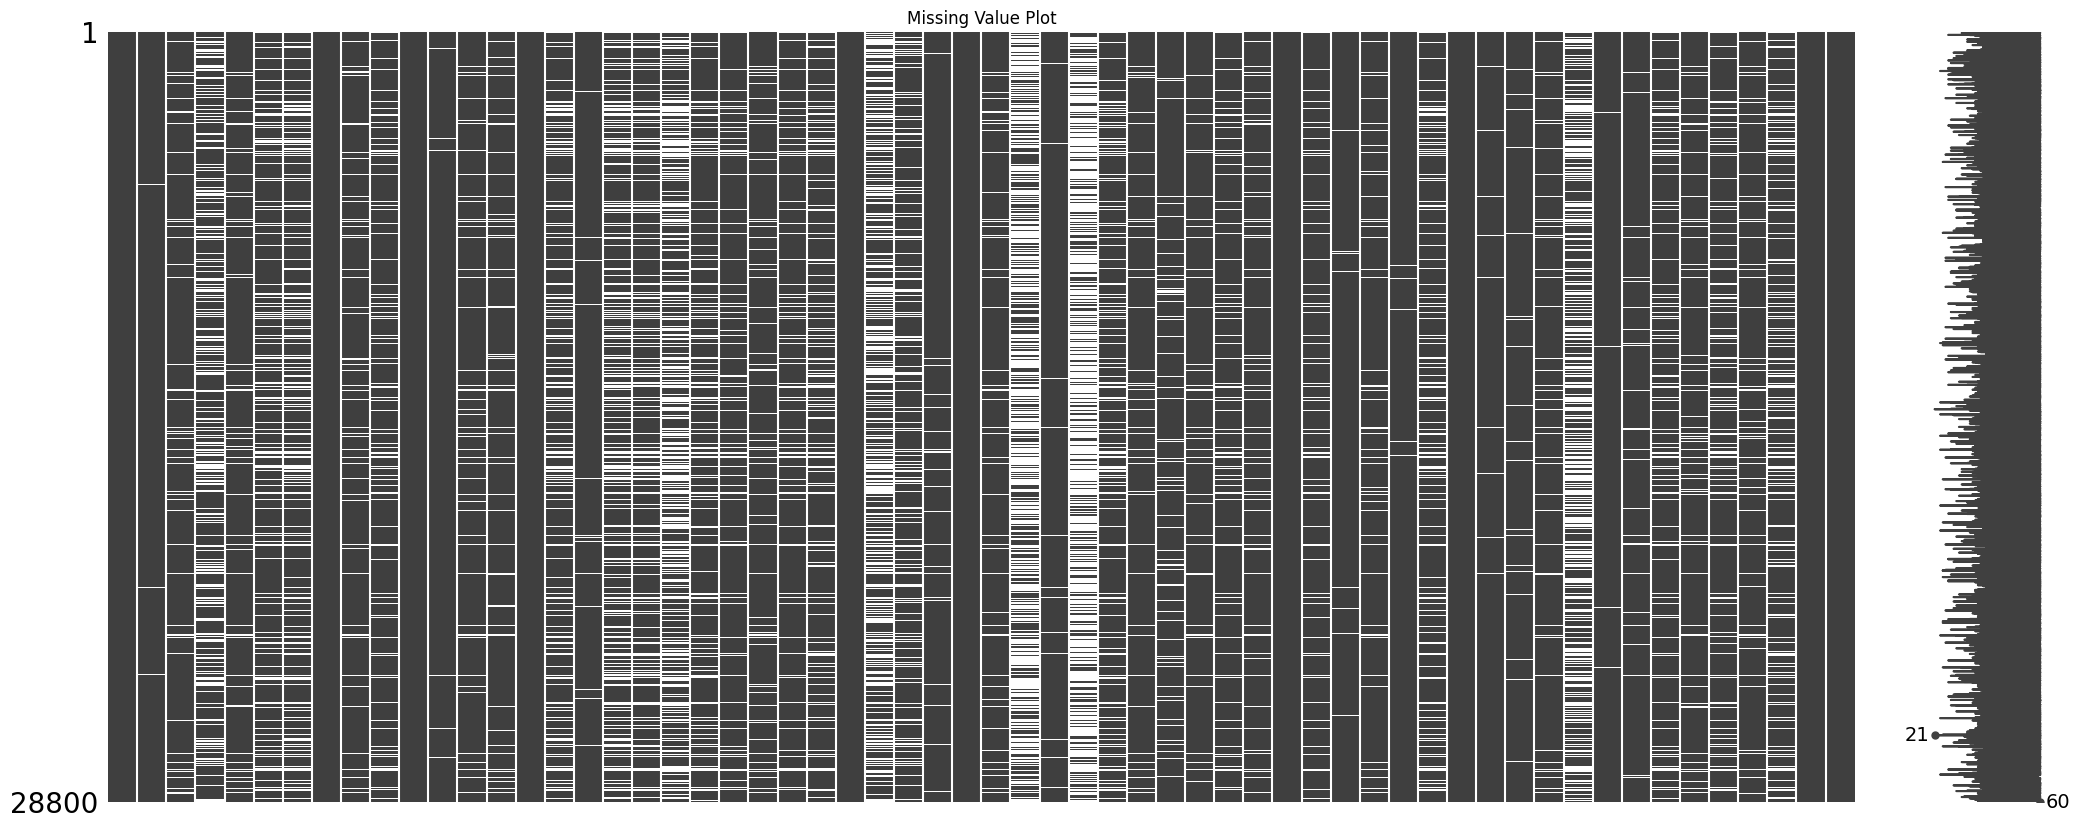

In [4]:
import matplotlib.pyplot as plt
import missingno as msno

msno.matrix(train_df)
plt.title("Missing Value Plot")
plt.show()

In [5]:
num_cols = train_df.select_dtypes(include=['number']).columns
cat_cols = train_df.select_dtypes(exclude=['number']).columns

train_df[num_cols] = train_df[num_cols].fillna(-1)
train_df[cat_cols] = train_df[cat_cols].fillna('unknown')

num_cols = test_df.select_dtypes(include=['number']).columns
cat_cols = test_df.select_dtypes(exclude=['number']).columns

test_df[num_cols] = test_df[num_cols].fillna(-1)
test_df[cat_cols] = test_df[cat_cols].fillna('unknown')

# Model

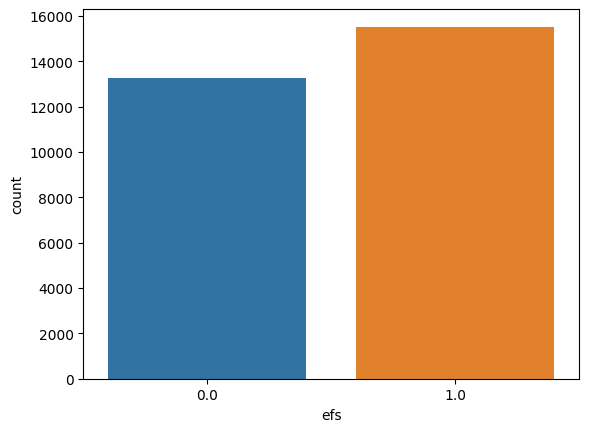

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='efs',data=train_df)
plt.show()

In [7]:
import lightgbm as lgb

target = 'efs'

X_train = train_df.dot
X_train = train_df.drop(columns=[target,'efs_time'])
y_train = train_df[target]

In [8]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

model = CatBoostClassifier(
    iterations=1000,       # Number of boosting iterations
    learning_rate=0.1,     # Learning rate
    depth=6,               # Depth of each tree
    cat_features=list(cat_cols),  # Pass categorical column indices or names
    verbose=100,           # Print training progress
    early_stopping_rounds=50  # Stop training if no improvement
)

In [9]:
model.fit(X_train, y_train, use_best_model=True)

You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 0.6793223	total: 171ms	remaining: 2m 50s
100:	learn: 0.5693865	total: 9.64s	remaining: 1m 25s
200:	learn: 0.5455731	total: 19.7s	remaining: 1m 18s
300:	learn: 0.5287106	total: 29.2s	remaining: 1m 7s
400:	learn: 0.5155776	total: 38.9s	remaining: 58s
500:	learn: 0.5042500	total: 49.1s	remaining: 48.9s
600:	learn: 0.4924521	total: 58.8s	remaining: 39s
700:	learn: 0.4822033	total: 1m 8s	remaining: 29.2s
800:	learn: 0.4731646	total: 1m 18s	remaining: 19.6s
900:	learn: 0.4631214	total: 1m 28s	remaining: 9.73s
999:	learn: 0.4535373	total: 1m 38s	remaining: 0us


In [10]:
y_pred = model.predict(test_df)

In [11]:
len(y_pred)

3

In [12]:
sub_df['prediction'] = y_pred

sub_df.to_csv('submission.csv', index=False)
display(sub_df.head())

,ID,prediction
0,28800,0.0
1,28801,1.0
2,28802,0.0
